<ipython-input-1-3047031211>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(pantheon_file, delim_whitespace=True, comment="#")


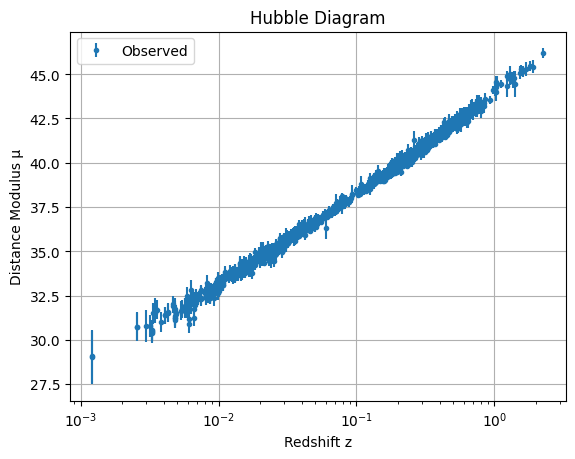

Best-fit H0: 72.97 km/s/Mpc
Best-fit Omega_m: 0.35


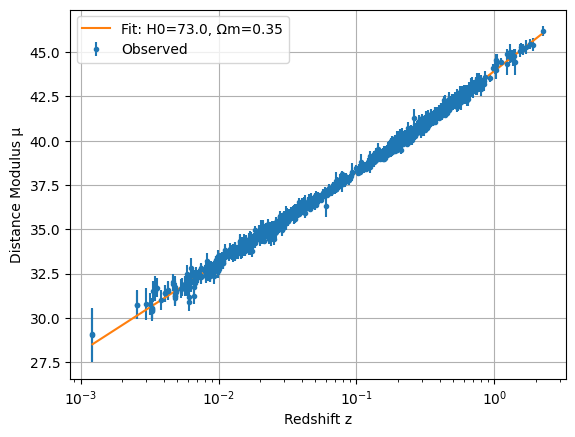

Estimated age of the universe: 12.36 Gyr


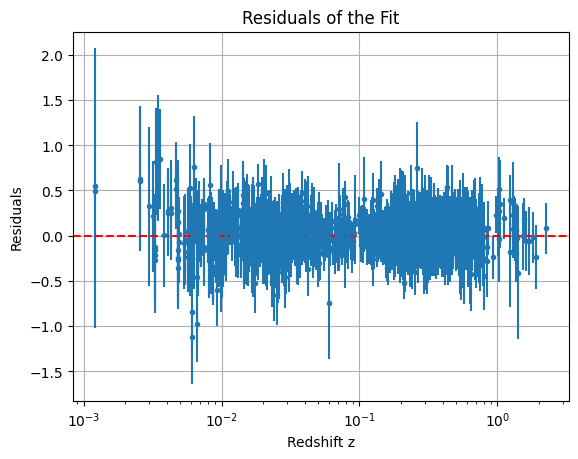

Fixed Omega_m=0.3, Best-fit H0: 73.53 km/s/Mpc
Low-z: H0 = 72.74, Ωm = 0.44
High-z: H0 = 73.18, Ωm = 0.34


In [1]:
# Measuring Cosmological Parameters Using Type Ia Supernovae

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

# Load Dataset
# Ensure 'Pantheon+SH0ES.dat' is downloaded and placed in the same directory
pantheon_file = "Pantheon+SH0ES.dat"
df = pd.read_csv(pantheon_file, delim_whitespace=True, comment="#")
z = df['zHD'].values
mu = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

# Hubble Diagram
plt.errorbar(z, mu, yerr=mu_err, fmt='.', label='Observed')
plt.xscale('log')
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus μ')
plt.title('Hubble Diagram')
plt.legend()
plt.grid(True)
plt.show()

# Cosmology Functions
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def luminosity_distance(z, H0, Omega_m):
    integral = np.array([quad(lambda z_: 1.0 / E(z_, Omega_m), 0, z_i)[0] for z_i in z])
    dL = (c / H0).to('Mpc') * (1 + z) * integral
    return dL

def distance_modulus(z, H0, Omega_m):
    dL = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(dL.value) + 25

def fit_function(z, H0, Omega_m):
    return distance_modulus(z, H0 * u.km/u.s/u.Mpc, Omega_m)

# Fit the model
popt, pcov = curve_fit(fit_function, z, mu, sigma=mu_err, p0=[70, 0.3])
H0_fit, Omega_m_fit = popt
print(f"Best-fit H0: {H0_fit:.2f} km/s/Mpc")
print(f"Best-fit Omega_m: {Omega_m_fit:.2f}")

# Plot Fit
z_fit = np.linspace(min(z), max(z), 200)
mu_fit = fit_function(z_fit, H0_fit, Omega_m_fit)

plt.errorbar(z, mu, yerr=mu_err, fmt='.', label='Observed')
plt.plot(z_fit, mu_fit, label=f'Fit: H0={H0_fit:.1f}, Ωm={Omega_m_fit:.2f}')
plt.xscale('log')
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus μ')
plt.legend()
plt.grid(True)
plt.show()

# Estimate Age of the Universe
def integrand(z, Omega_m):
    return 1.0 / ((1 + z) * E(z, Omega_m))

age, _ = quad(integrand, 0, np.inf, args=(Omega_m_fit,))
age_Gyr = age / (H0_fit / 100) * 9.78
print(f"Estimated age of the universe: {age_Gyr:.2f} Gyr")

# Residuals
mu_model = fit_function(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model

plt.errorbar(z, residuals, yerr=mu_err, fmt='.')
plt.axhline(0, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel('Redshift z')
plt.ylabel('Residuals')
plt.title('Residuals of the Fit')
plt.grid(True)
plt.show()

# Fit with fixed Omega_m = 0.3
def fit_fixed_Omega_m(z, H0):
    return distance_modulus(z, H0 * u.km/u.s/u.Mpc, 0.3)

H0_fixed_fit, _ = curve_fit(fit_fixed_Omega_m, z, mu, sigma=mu_err, p0=[70])
print(f"Fixed Omega_m=0.3, Best-fit H0: {H0_fixed_fit[0]:.2f} km/s/Mpc")

# Compare low-z vs high-z
z_split = 0.1
low_mask = z < z_split
high_mask = z >= z_split

popt_low, _ = curve_fit(fit_function, z[low_mask], mu[low_mask], sigma=mu_err[low_mask], p0=[70, 0.3])
popt_high, _ = curve_fit(fit_function, z[high_mask], mu[high_mask], sigma=mu_err[high_mask], p0=[70, 0.3])

print(f"Low-z: H0 = {popt_low[0]:.2f}, Ωm = {popt_low[1]:.2f}")
print(f"High-z: H0 = {popt_high[0]:.2f}, Ωm = {popt_high[1]:.2f}")
